# Web Intrusion Detection

## Importing Libraries

In [107]:
from __future__ import division, print_function
## to ignore warnings as we don't like them as such
import warnings
warnings.filterwarnings('ignore')
#plotting lib's
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
#other's
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_predict, TimeSeriesSplit
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.metrics import confusion_matrix
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score , roc_curve, auc
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

### Loading Train and Test Datasets

In [108]:
# Read the training and test data sets
train_df = pd.read_csv('Project 1/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/train_sessions.csv',
                       index_col='session_id',parse_dates=['time1'])
test_df = pd.read_csv('Project 1/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/test_sessions.csv',
                      index_col='session_id',parse_dates=['time1'])

times = ['time%s' % i for i in range(1, 11)]
sites = ['site%s' % i for i in range(1, 11)]

In [109]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [110]:
train_df.shape, test_df.shape

((253561, 21), (82797, 20))

In [111]:
# Load websites dictionary
with open(r"Project 1/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])
print(u'Websites total:', sites_dict.shape[0])

Websites total: 48371


In [112]:
sites_dict

,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu
...,...
29738,i1-js-14-3-01-11074-747051290-i.init.cedexis-r...
40794,i1-js-14-3-01-12434-548464295-i.init.cedexis-r...
10939,embed.api.tv
40028,n-tennis.fr


## Preprocessing

In [113]:
# Here we are converting the time column of the dataset into pandas datetime object
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

# Change site1, ..., site10 columns type to integer and fill NA-values with zeros

train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

## Basic EDA

<Axes: xlabel='target', ylabel='count'>

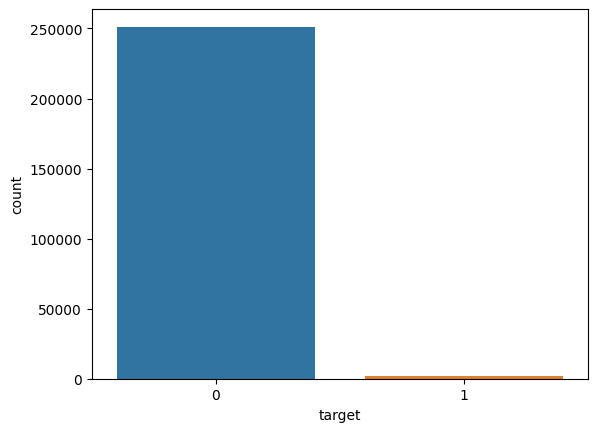

In [114]:
sns.countplot(x =train_df['target']) #Imbalanced Dataset

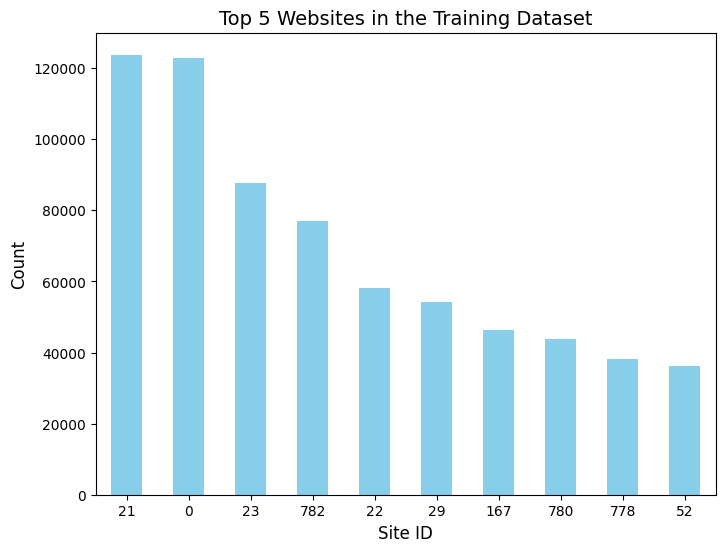

In [115]:
# Top websites in the training data set
top_sites = pd.Series(train_df[sites].fillna(0).values.flatten()
                     ).value_counts().sort_values(ascending=False).head(10)
plt.figure(figsize=(8, 6))
top_sites.plot(kind='bar', color='skyblue')

plt.title('Top 5 Websites in the Training Dataset', fontsize=14)
plt.xlabel('Site ID', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)

# Display the plot
plt.show()

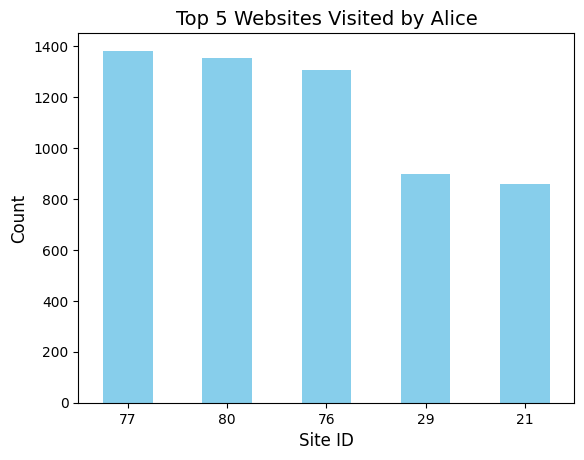

In [116]:
# Alice's preferences
top_sites_alice = pd.Series(train_df[train_df.target==1][sites].fillna(0).values.flatten()
                           ).value_counts().sort_values(ascending=False).head()
top_sites_alice.plot(kind='bar', color='skyblue')

plt.title('Top 5 Websites Visited by Alice', fontsize=14)
plt.xlabel('Site ID', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)

# Display the plot
plt.show()

### Feature Engineering

In [117]:
# TRAIN DATA
time_df = pd.DataFrame(index=train_df.index)
time_df['target'] = train_df['target']

# Find sessions' starting and ending
time_df['min'] = train_df[times].min(axis=1)
time_df['max'] = train_df[times].max(axis=1)

# Calculate sessions' duration in seconds
time_df['seconds'] = (time_df['max'] - time_df['min']) / np.timedelta64(1, 's')


# TEST DATA
time_df_test = pd.DataFrame(index=test_df.index)

# Find sessions' starting and ending
time_df_test['min'] = test_df[times].min(axis=1)
time_df_test['max'] = test_df[times].max(axis=1)

# Calculate sessions' duration in seconds
time_df_test['seconds'] = (time_df_test['max'] - time_df_test['min']) / np.timedelta64(1, 's')

- y_train - our target variable 

- full_df - the merged table of input data (training and test samples together) 

* idx_split - the index by which we will separate the training sample from the test


In [118]:
# Our target variable
y_train = train_df['target']

# United dataframe of the initial data 
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]

In [119]:
idx_split

253561

In [120]:
full_df.head(5)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,945,2013-01-12 08:50:16,948,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,946,2013-01-12 08:50:18,947,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,952,2013-01-12 08:50:21,946,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22


In [121]:
full_sites = full_df[sites] #only sites
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


## Creating characteristics

- Extracting attributes from the site table 

- Count the number of unique sites in each session

In [122]:
full_time  =  full_df[times] 
full_time.head(3)

,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
session_id,,,,,,,,,,
21669,2013-01-12 08:05:57,2013-01-12 08:05:57,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
54843,2013-01-12 08:37:23,2013-01-12 08:37:23,2013-01-12 09:07:07,2013-01-12 09:07:09,NaT,NaT,NaT,NaT,NaT,NaT
77292,2013-01-12 08:50:13,2013-01-12 08:50:14,2013-01-12 08:50:15,2013-01-12 08:50:15,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:17,2013-01-12 08:50:17


**We calculate the time of staying on each site within one session**

In [123]:
def get_time_diff (row): 
    time_length = row.shape[0] - 1 
    time_diff = [0]*time_length 
    i = 0 
    while (i < time_length)and pd.notnull(row[i+1]): 
        time_diff[i] = (row[i+1] - row[i]) /np.timedelta64(1,'s') 
        i += 1 
    return  time_diff

# This returns the time difference bewteen adjacent cols of a row and populates it in the time_length array

In [124]:
%%time
time_diff = []
for row in full_time.values:
    time_diff.append (get_time_diff (row))
time_diff = np.log1p(np.array(time_diff).astype(float)) # log is to help us with absolutely small values or 0 values

CPU times: total: 15.8 s
Wall time: 17.7 s


In [125]:
## Appending The Newly Created Features
time_names = ['time_diff'+str(j) for j in range(1,10)] 
for ind,column_name in enumerate(time_names): 
    additional_data_df[column_name] = time_diff[:,ind] 

**We will calculate the total time spent at each session**

In [126]:
def get_total_time(row): 
    time_length = row.shape[0] - 1 
    i = time_length 
    while pd.isnull( row [ i ]): 
        i -= 1 
    return (row[i] - row[0]) / np.timedelta64(1,'s')

In [127]:
%%time
total_time = []
for row in full_time.values:
    total_time.append(get_total_time(row))
total_time = np.array(total_time).reshape(-1,1).astype(int)

CPU times: total: 1.84 s
Wall time: 2.2 s


In [128]:
additional_data_df['total_time'] =  total_time 
additional_data_df['total_time'] =  np.log1p(additional_data_df['total_time'].values)

In [129]:
additional_data_df['start_hour']  =  full_time['time1'].apply(lambda ts: ts.hour) 
additional_data_df['holiday']     = (full_time['time1'].dt.dayofweek >= 5).astype(int) 
additional_data_df['day_of_week'] = (full_time['time1'].dt.dayofweek).astype(int)

In [130]:
additional_data_df.head(5)

,unique,have_top_10,absolutely_unique_count,have_absolutely_unique,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,total_time,start_hour,holiday,day_of_week
session_id,,,,,,,,,,,,,,,,,
21669,2,0,0,0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,8,1,5
54843,2,0,0,0,0.000000,7.487174,1.098612,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,7.488294,8,1,5
77292,6,0,0,0,0.693147,0.693147,0.000000,0.693147,0.0,0.000000,0.000000,0.693147,0.000000,1.609438,8,1,5
114021,5,0,0,0,0.000000,0.693147,0.000000,0.000000,0.0,0.693147,0.000000,0.000000,0.693147,1.386294,8,1,5
146670,6,0,0,0,0.000000,0.000000,0.693147,0.000000,0.0,0.000000,0.693147,0.000000,0.000000,1.098612,8,1,5


In [131]:
add_data_train = additional_data_df[: idx_split ].copy() 
add_data_test  = additional_data_df[ idx_split :]

### Analysis of training and test samples 

In [132]:
add_data_train.loc[:, 'target' ]= y_train

**Let's see what signs we have**

In [133]:
dtype_df = add_data_train.dtypes.reset_index() 
dtype_df.columns = ['Column_name','Column_type'] 
dtype_df

,Column_name,Column_type
0,unique,int32
1,have_top_10,int32
2,absolutely_unique_count,int32
3,have_absolutely_unique,int32
4,time_diff1,float64
5,time_diff2,float64
6,time_diff3,float64
7,time_diff4,float64
8,time_diff5,float64
9,time_diff6,float64


**Let's look at the correlation table of the dataset**

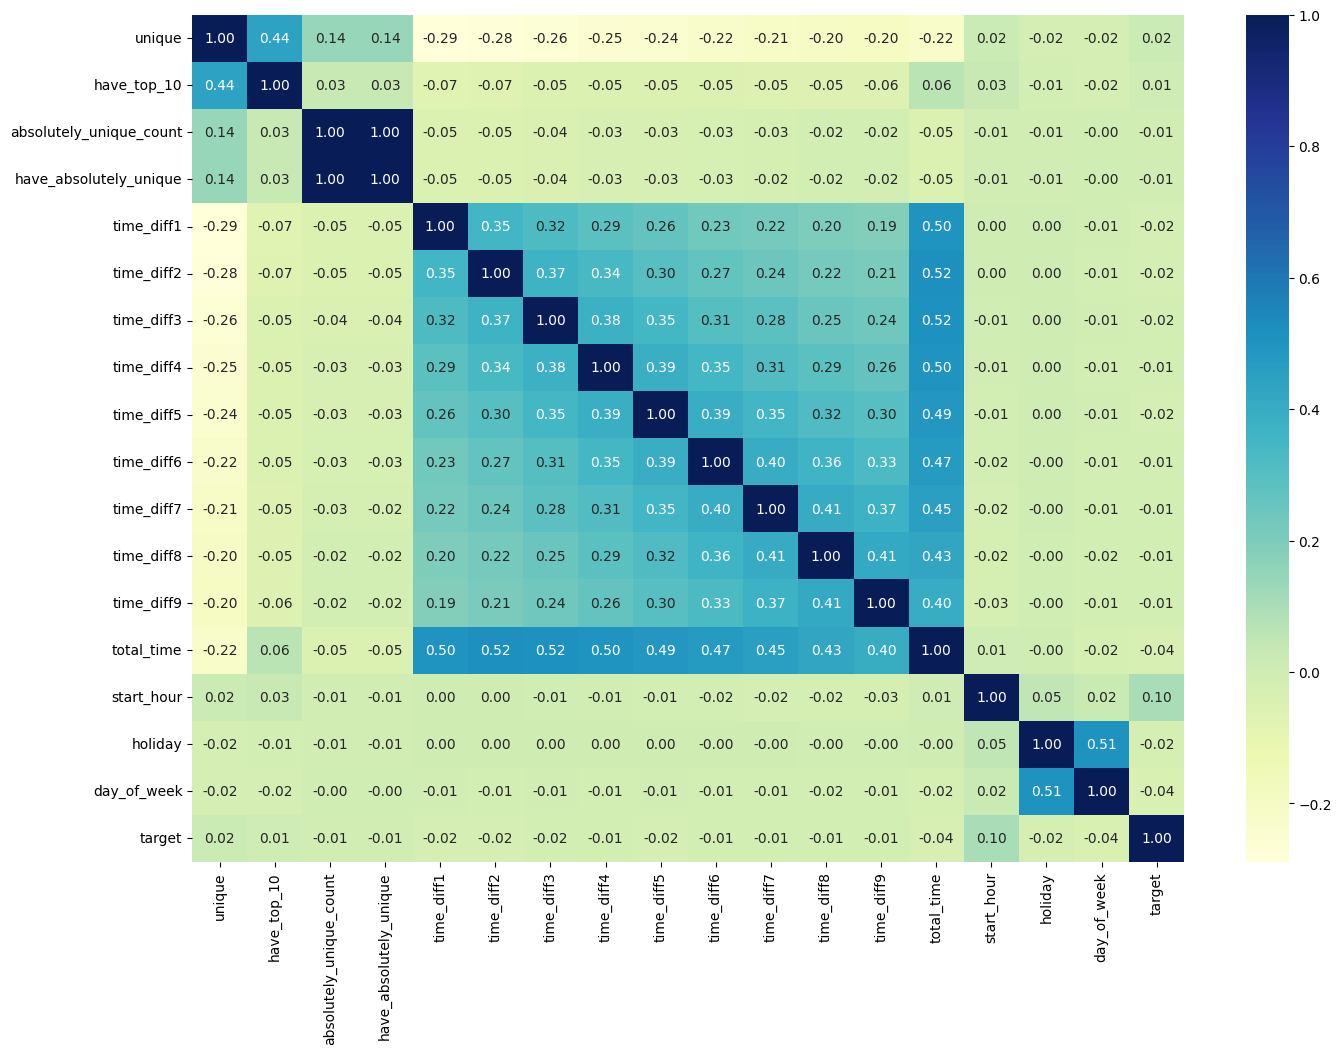

In [134]:
corr = add_data_train.corr('spearman') 
plt.figure(figsize = ( 16 , 11 )) 
sns.heatmap(corr,annot=True,fmt='.2f',cmap="YlGnBu"); 
# plotting a correlation matrix to check for multi-colleniarity and to check the variables that
# are correlated to the target value

**Let's look at the distribution of some features**

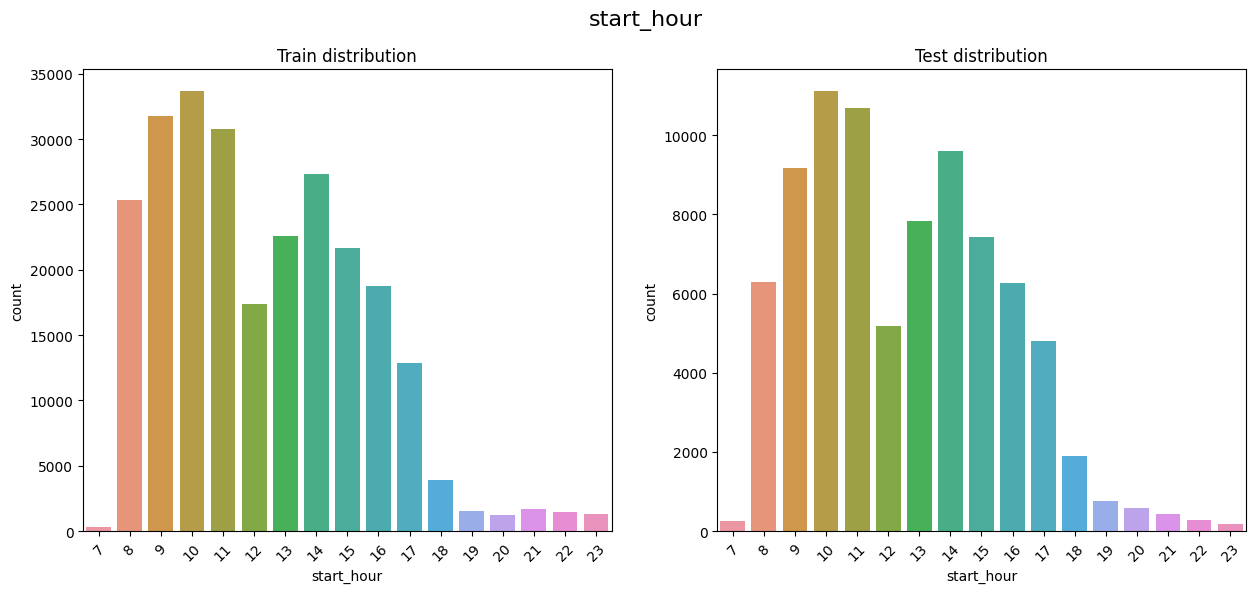

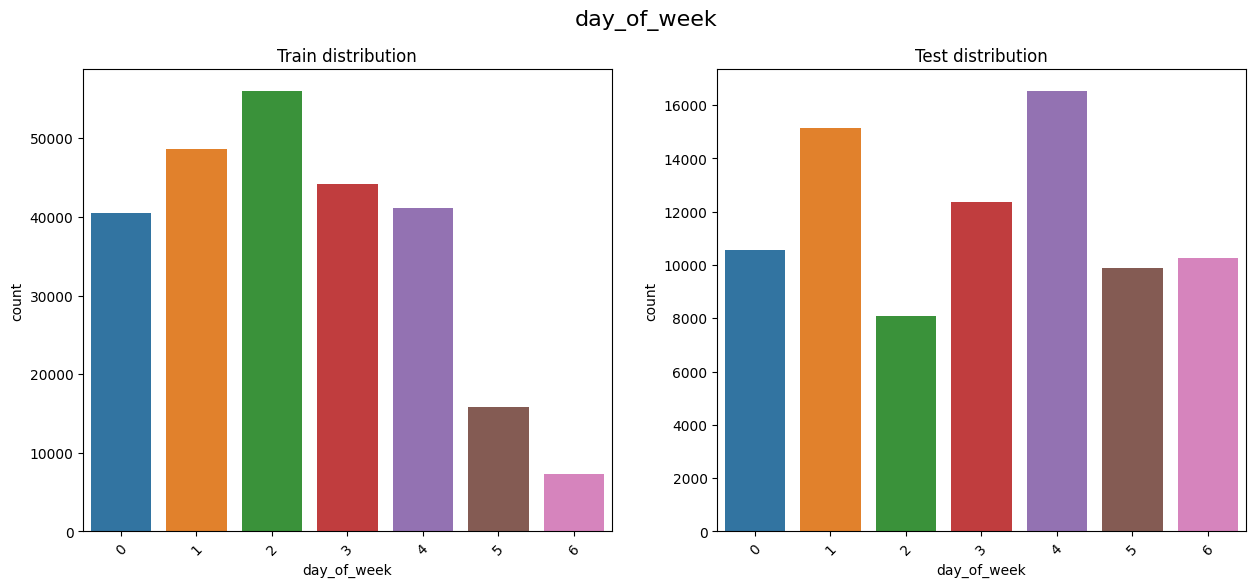

In [135]:
feature_list = ['start_hour','day_of_week'] 
for  column_name in feature_list: 
    fig , (ax1,ax2) = plt.subplots(1,2,figsize = ( 15 , 6 )) 
    fig.suptitle(column_name,fontsize=16) 
    sns.countplot(x = add_data_train[column_name],ax=ax1) 
    ax1.set_title("Train distribution") 
    for tick in ax1.get_xticklabels(): 
        tick.set_rotation(45)
    sns.countplot(x = add_data_test[column_name],ax=ax2) 
    ax2.set_title("Test distribution") 
    for tick in ax2.get_xticklabels(): 
        tick.set_rotation(45)

- As you can see, all the attributes are distributed approximately equally in the training and test sample. 

- The start_hour attribute is distributed from 7 to 23 hours, and not from 0 to 23 hours, as expected.

- We will analyze the effect of the characteristics on the target variable

In [136]:
def get_target_dist( column_name ): 
    fig , (ax1,ax2) = plt.subplots(1,2,figsize = (15,6)) 
    fig.suptitle(column_name,fontsize=16) 
    sns.countplot(x = add_data_train[add_data_train['target'] == 1][column_name],ax=ax1) 
    ax1.set_title("Intruder count (target: 1)") 
    for tick in ax1.get_xticklabels(): 
        tick.set_rotation(45)
    sns.barplot(x=column_name,y="target",data=add_data_train,ax=ax2) 
    ax2.set_title("Intruder proportion (target: 1)") 
    for tick in ax2.get_xticklabels(): 
        tick.set_rotation(45)

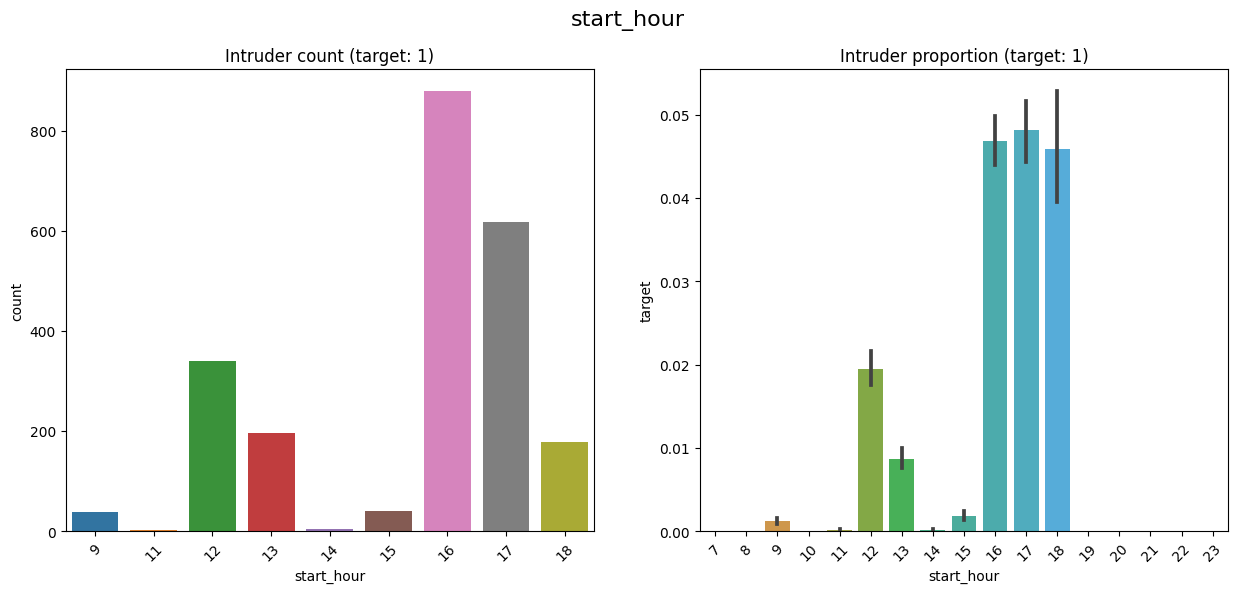

In [137]:
get_target_dist('start_hour')

Frauds were recorded between 9 and 18 hours, with the period from 16 to 18 hours most saturated with suspicious activity. On the basis of this, we will distinguish 3 features:

- morning: 7 - 11
- midday: 12 - 15
- evening: 16 - 20

In [138]:
add_data_train['morning']  = add_data_train['start_hour'].apply(lambda hour:int(hour >= 7 and hour <= 11 )) 
add_data_train['midday']   = add_data_train['start_hour'].apply(lambda hour:int(hour >= 12 and hour <= 18)) 
add_data_train['evening']  = add_data_train['start_hour'].apply(lambda hour:int(hour >= 19 and hour <= 23))
add_data_train['night']    = add_data_train['start_hour'].apply(lambda hour:int(hour >= 0 and hour <= 6))

add_data_test['morning'] = add_data_test['start_hour'].apply(lambda hour:int(hour >= 7 and hour <= 12 )) 
add_data_test['midday']  = add_data_test['start_hour'].apply(lambda hour:int(hour >= 12 and hour <= 18)) 
add_data_test['evening'] = add_data_test['start_hour'].apply(lambda hour:int(hour >= 19 and hour <= 23))
add_data_test['night']   = add_data_test['start_hour'].apply(lambda hour:int(hour >= 0 and hour <= 6))

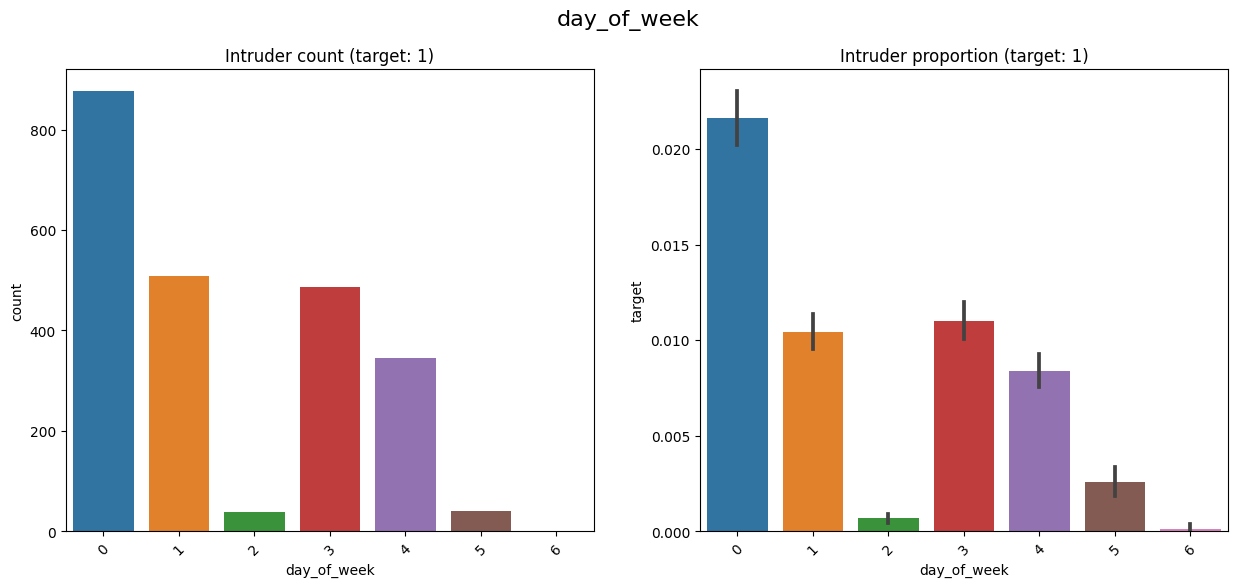

In [139]:
get_target_dist('day_of_week')

**The least suspicious activity was on Wednesdays, Saturdays and Sundays. But on Mondays(0), on the contrary, more than on other days.**

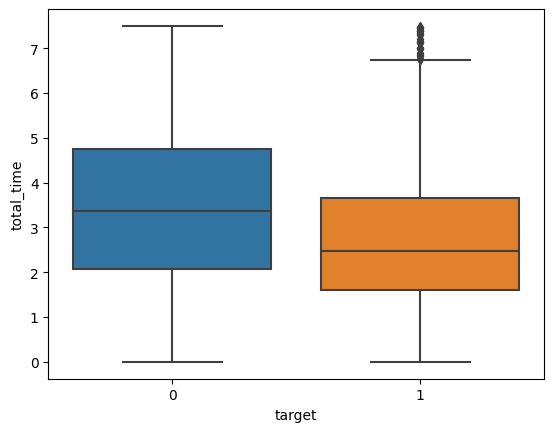

In [140]:
ax = sns.boxplot(x = 'target', y = 'total_time', data = add_data_train)

The duration of sessions with suspicious activity is on average less than that of the usual ones.

**General observations:**

- Most often, suspicious activity was seen between 16 and 18 hours
- Also on Mondays, suspicious activity occurs most often
- On average, the duration of sessions with suspicious activity is less than that of conventional
- Suspicious sessions are less common absolutely unique sites (sites that occur only once in the history of visiting sites)

 Adding Cyclic Co-ordinates

## Training Models

### Preprocessing data 
- Convert categorical variables to dummies using get_dummies

In [141]:
add_train_dummies  = pd.get_dummies(add_data_train , columns=['day_of_week']) # creating a one hot encoded table of all the categorical values
add_train_dummies.drop(['target'],axis = 1,inplace=True) 
add_test_dummies  = pd.get_dummies(add_data_test,columns=['day_of_week']) # creating a one hot encoded table of all the categorical values

In [142]:
idx_split

253561

In [143]:
names_for_scale  =  ['time_diff' + str(x) for x in range (1,10)]  +  ['unique','absolutely_unique_count','total_time'] 
scaler = StandardScaler() 
for column_name in names_for_scale : 
    add_train_dummies[column_name] =scaler.fit_transform(add_train_dummies[column_name].values.reshape(-1,1)) 
    add_test_dummies[column_name]  =scaler.transform(add_test_dummies[column_name].values.reshape(-1,1))

In [144]:
# Sequence with indexes 
sites_flatten = full_sites.values.flatten()
# 
full_sites_sparse=csr_matrix(([1]  *  sites_flatten . shape [ 0 ], sites_flatten ,  
                                range(0,sites_flatten.shape[0]+10,10)))[:,1:]

X_train_sparse  =  full_sites_sparse [: idx_split ] 
X_test_sparse  =  full_sites_sparse [ idx_split :] 
full_sites_sparse.shape #(336358, 48371)

(336358, 48371)

In [145]:
full_sites = full_df[sites].astype('str')
lst = full_sites[sites].values.tolist()
flat_list = [' '.join(sublist) for sublist in lst]
vect = TfidfVectorizer(ngram_range=(1,4), max_features=100000,analyzer='char_wb')
tfidf_matrix = vect.fit_transform(flat_list)

X_train_tf = tfidf_matrix[:idx_split]
X_test_tf  = tfidf_matrix[idx_split:]

X_train_tf.shape, X_test_tf.shape

((253561, 13321), (82797, 13321))

In [146]:
# Convert all columns in the dummy variables to numeric (if needed)
add_train_dummies = add_train_dummies.apply(pd.to_numeric, errors='coerce')
add_test_dummies = add_test_dummies.apply(pd.to_numeric, errors='coerce')
# Convert all boolean columns to 0 and 1
add_train_dummies = add_train_dummies.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)
add_test_dummies = add_test_dummies.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)


In [147]:
print(add_train_dummies.dtypes)

unique                     float64
have_top_10                  int32
absolutely_unique_count    float64
have_absolutely_unique       int32
time_diff1                 float64
time_diff2                 float64
time_diff3                 float64
time_diff4                 float64
time_diff5                 float64
time_diff6                 float64
time_diff7                 float64
time_diff8                 float64
time_diff9                 float64
total_time                 float64
start_hour                   int64
holiday                      int32
morning                      int64
midday                       int64
evening                      int64
night                        int64
day_of_week_0                uint8
day_of_week_1                uint8
day_of_week_2                uint8
day_of_week_3                uint8
day_of_week_4                uint8
day_of_week_5                uint8
day_of_week_6                uint8
dtype: object


**Combine the site matrix and additional features**

In [148]:
x_train_full  =  csr_matrix(hstack([X_train_tf,add_train_dummies.values])) 
x_test_full   =  csr_matrix(hstack([X_test_tf ,add_test_dummies.values])) 
x_train_full.shape,x_test_full.shape

((253561, 13348), (82797, 13348))

In [149]:
target = train_df['target']
X_train , X_valid , y_train , y_valid = train_test_split(x_train_full,target ,test_size=0.2) 
tscv = TimeSeriesSplit(n_splits = 5)

In [150]:
tscv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)

In [151]:
[(el[0].shape, el[1].shape) for el in tscv.split(X_train)]

[((33808,), (33808,)),
 ((67616,), (33808,)),
 ((101424,), (33808,)),
 ((135232,), (33808,)),
 ((169040,), (33808,))]

**Since our classes are highly unbalanced, the accuracy metric here does not fit.**

**We will use ROC_AUC as a metric, and also look at the results of confusion_matrix**

Since we have historical data, interrelated with time, the standard cross-fitting in this case will not work. We will use cross-validation with TimeSeriesSplit - cross-validation techniques for time series. 
Its essence lies in the following: we divide the sample, for example, into 5 parts: [1, 2, 3, 4, 5], then we train in the following way

- Fold 1: training [1], Test [2]
- Fold 2: Training [1, 2], Test [3]
- Fold 3: teaching [1, 2, 3], Test [4]
- Fold 4: training [1, 2, 3, 4], Test [5]

**This approach will help to better evaluate the quality of the algorithm.**

In [152]:
%%time
clf_lr = LogisticRegression (random_state = 42, n_jobs=1, solver='lbfgs', max_iter=8000)
clf_lr.fit (X_train, y_train)
preds_lr = clf_lr.predict_proba (X_valid)[:, 1]
print ('Train test split LogisticRegression score:% s ROC AUC'% round (roc_auc_score (y_valid, preds_lr), 4))
cross_score_lr = np.mean (cross_val_score (clf_lr, x_train_full, target, scoring = 'roc_auc', cv = tscv))
print ('Cross validation LogisticRegression score:% s ROC AUC'% round (cross_score_lr, 4))

Train test split LogisticRegression score:0.9776 ROC AUC
Cross validation LogisticRegression score:0.9108 ROC AUC
CPU times: total: 8.5 s
Wall time: 2min 7s


In [153]:
%%time
clf_rf = RandomForestClassifier (random_state = 42, n_estimators = 100)
clf_rf.fit (X_train, y_train)
preds_rf = clf_rf.predict_proba (X_valid) [:, 1]
print ('Train test split RandomForestClassifier score:% s ROC AUC'% round (roc_auc_score (y_valid, preds_rf), 4))
cross_score_rf = np.mean (cross_val_score (clf_rf, x_train_full, target, scoring = 'roc_auc', cv = tscv))
print ('Cross validation RandomForestClassifier score:% s ROC AUC'% round (cross_score_rf, 4))

Train test split RandomForestClassifier score:0.9698 ROC AUC
Cross validation RandomForestClassifier score:0.8435 ROC AUC
CPU times: total: 13min 58s
Wall time: 14min 26s


Text(0.5, 0, 'False Positive Rate')

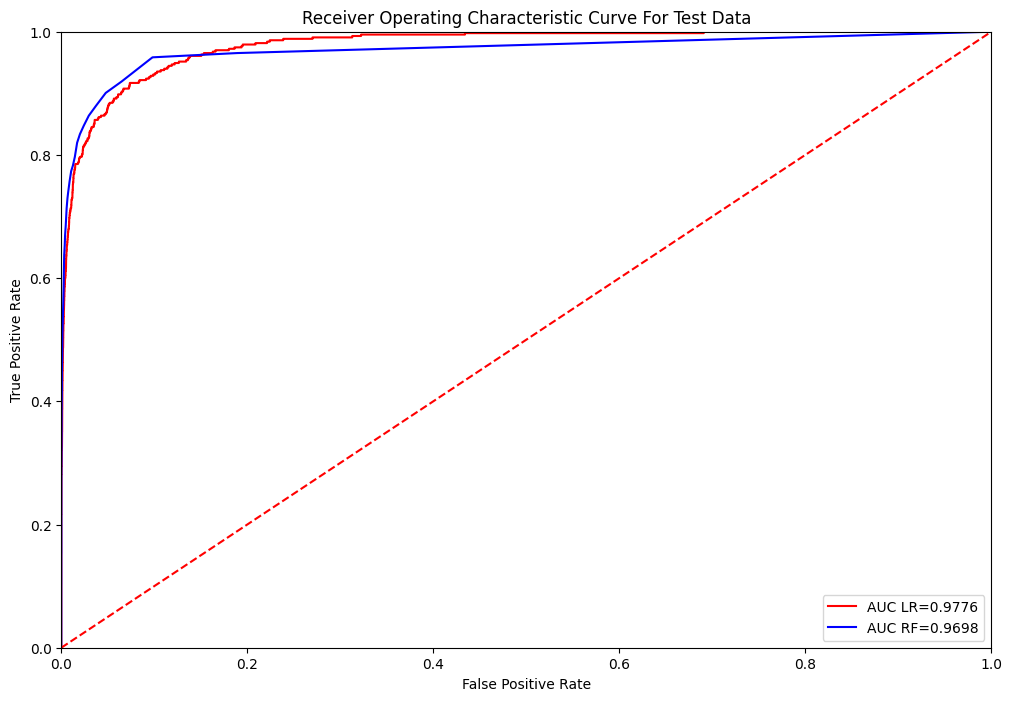

In [154]:
fpr_lr,tpr_lr,threshold=roc_curve(y_valid,preds_lr)
roc_auc_lr = auc(fpr_lr,tpr_lr)

fpr_rf,tpr_rf,threshold=roc_curve(y_valid,preds_rf)
roc_auc_rf = auc(fpr_rf,tpr_rf)


plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic Curve For Test Data')
plt.plot(fpr_lr, tpr_lr,'r', label='AUC LR=%0.4f'%roc_auc_lr)
plt.plot(fpr_rf, tpr_rf,'b', label='AUC RF=%0.4f'%roc_auc_rf)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

Text(0.5, 1.0, 'Confu')

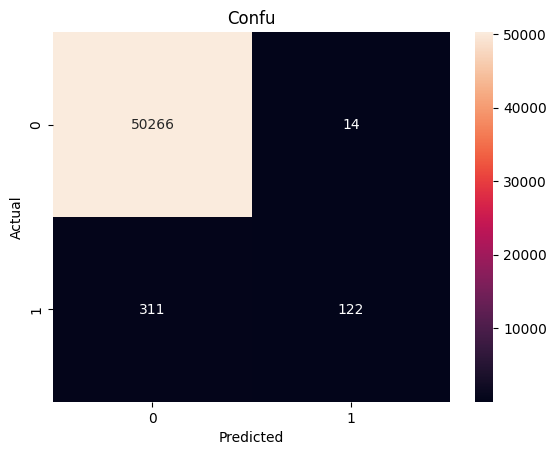

In [163]:
pred_lr = clf_lr.predict(X_valid)

con_lr = confusion_matrix(y_valid,pred_lr)
sns.heatmap(con_lr, annot=True,fmt="d")
plt.title("Confusion Matrix for Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confu")

Text(50.722222222222214, 0.5, 'Actual')

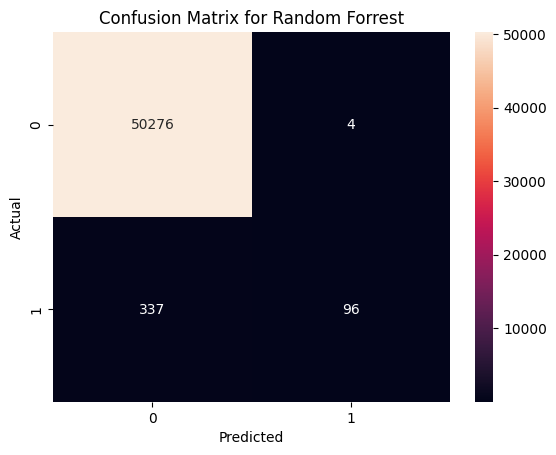

In [157]:
pred_rf = clf_rf.predict(X_valid)

con_lr = confusion_matrix(y_valid,pred_rf)
sns.heatmap(con_lr, annot=True,fmt="d")
plt.title("Confusion Matrix for Random Forrest")
plt.xlabel("Predicted")
plt.ylabel("Actual")